In [47]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
import re
import os
import numpy as np
from glob import glob
import pandas as pd


In [48]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#Load Model

In [49]:
model_name = "facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else -1

In [50]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        framework="pt",
        device=device
    )
    return theme_classifier

In [51]:
theme_classifier = load_model(device)

In [52]:
theme_list = ["friendship","perseverance","dialogue","sacrifice","magic vs effort","self-discovery","teamwork","overcoming adversity"]

In [53]:
theme_classifier(
    "I tried my hardest even though I was born without magic",
    theme_list,
    multi_label=True
)

{'sequence': 'I tried my hardest even though I was born without magic',
 'labels': ['perseverance',
  'overcoming adversity',
  'sacrifice',
  'magic vs effort',
  'self-discovery',
  'dialogue',
  'teamwork',
  'friendship'],
 'scores': [0.973241925239563,
  0.9624465703964233,
  0.8755594491958618,
  0.6383119225502014,
  0.27197927236557007,
  0.054969243705272675,
  0.050298213958740234,
  0.025358907878398895]}

In [54]:
# Load Dataset

In [55]:
files = glob('../data/Subtitles/*.ass')
files_sorted = sorted(files, key=lambda x: int(re.findall(r'\d+', x)[0]))

In [56]:
files_sorted[:5]

['../data/Subtitles\\1.ass',
 '../data/Subtitles\\2.ass',
 '../data/Subtitles\\3.ass',
 '../data/Subtitles\\4.ass',
 '../data/Subtitles\\5.ass']

In [57]:
with open(files_sorted[0], 'r') as file:
    lines = file.readlines()
    lines = lines[30:]
    lines = [",".join(line.split(',')[9:]) for line in lines]

In [58]:
lines[:2]

['A Village Out in the Boonies: Hage\n', 'Here we go again...\n']

In [59]:
" ".join(lines[:10])

"A Village Out in the Boonies: Hage\n Here we go again...\n There, there...\n There you are.\n Those two finally calmed down.\n Are they brothers... or perhaps twins?\n No, they're not.\n This one is rather calm, but this one...\n seems like he has a lot of spunk.\n First of all, they don't look a thing alike.\n"

In [60]:
int(files_sorted[0].split('\\')[-1].split('.')[0].strip())

1

In [61]:
def load_subtitles_dataset(dataset_path):
    subtitles_paths = glob(dataset_path + '/*.ass')

    # Sort files by the numeric part in the filename
    subtitles_paths = sorted(subtitles_paths, key=lambda x: int(re.findall(r'\d+', os.path.basename(x))[0]))

    scripts = []
    episode_num = []

    for path in subtitles_paths:
        # Read Lines with correct encoding
        with open(path, 'r', encoding='latin-1', errors='ignore') as file:
            lines = file.readlines()

            # Skip metadata or header lines (e.g., first 30 lines)
            lines = lines[30:]

            # Process lines: Remove \N, join the rest, and ensure sentences are properly separated
            # Replace \N with a space, strip unnecessary spaces, and join with a newline '\n'
            lines = [",".join(line.split(',')[9:]).replace('\\N', ' ').strip() for line in lines if line.strip()]

        # Join the lines with a newline '\n' for consistent sentence separation
        script = "\n ".join(lines)  # Ensure every sentence ends with '\n'

        # Extract the episode number from the filename
        try:
            episode = int(re.findall(r'\d+', os.path.basename(path))[0])
        except ValueError:
            print(f"Skipping file: {path}")
            continue

        scripts.append(script)
        episode_num.append(episode)

    # Create a DataFrame from the episodes and scripts
    df = pd.DataFrame({"episode": episode_num, "script": scripts})
    return df

In [62]:
dataset_path = "../data/Subtitles"
df = load_subtitles_dataset(dataset_path)

In [63]:
df.head()

,episode,script
0,1,A Village Out in the Boonies: Hage\n Here we g...
1,2,Not yet. I'm not finished...\n I'm going to be...
2,3,It appeared as though humanity would be destr...
3,4,It appeared as though humanity would be destr...
4,5,It appeared as though humanity would be destr...


In [64]:
#Run Model

In [65]:
script = df.iloc[0]['script']

In [66]:
script

'A Village Out in the Boonies: Hage\n Here we go again...\n There, there...\n There you are.\n Those two finally calmed down.\n Are they brothers... or perhaps twins?\n No, they\'re not.\n This one is rather calm, but this one...\n seems like he has a lot of spunk.\n First of all, they don\'t look a thing alike.\n Hm? "Yuno"...\n Let\'s see. And the spunky one over here isâ\x80\x94\n Hey! You\'re a bit too spunky...\n "Asta," eh?\n Right! You two don\'t need to  worry about a thing anymore.\n Starting today, this is your new home...\n Asta, Yuno.\n {\\fad(1,958)}15 Years Later\n Hopefully, we\'ll have a  great harvest this year.\n Yeah.\n Hup.\n Sister Lily!\n What the...\n Must be that runt from the church again.\n I\'ll become the Wizard King  someday and make you happy!\n So please marry me!\n I\'m sorry, Asta, but I\'m everyone\'s sister.\n Not yet!\n Um... I\'m sorry.\n I\'m not giving up yet!\n Er, um... But...\n I\'m not giving up!\n I\'m really sorry!\n One more time, Sister Li

In [67]:
script_sentences = sent_tokenize(script)
script_sentences[:3]

['A Village Out in the Boonies: Hage\n Here we go again...',
 'There, there...',
 'There you are.']

In [68]:
sentence_batch_size = 20
script_sentences = script.split("\n ")  # Split sentences by newline
script_batches = []
for index in range(0, len(script_sentences), sentence_batch_size):
    sent = "\n ".join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent)

In [69]:
script_batches[:2]

['A Village Out in the Boonies: Hage\n Here we go again...\n There, there...\n There you are.\n Those two finally calmed down.\n Are they brothers... or perhaps twins?\n No, they\'re not.\n This one is rather calm, but this one...\n seems like he has a lot of spunk.\n First of all, they don\'t look a thing alike.\n Hm? "Yuno"...\n Let\'s see. And the spunky one over here isâ\x80\x94\n Hey! You\'re a bit too spunky...\n "Asta," eh?\n Right! You two don\'t need to  worry about a thing anymore.\n Starting today, this is your new home...\n Asta, Yuno.\n {\\fad(1,958)}15 Years Later\n Hopefully, we\'ll have a  great harvest this year.\n Yeah.',
 "Hup.\n Sister Lily!\n What the...\n Must be that runt from the church again.\n I'll become the Wizard King  someday and make you happy!\n So please marry me!\n I'm sorry, Asta, but I'm everyone's sister.\n Not yet!\n Um... I'm sorry.\n I'm not giving up yet!\n Er, um... But...\n I'm not giving up!\n I'm really sorry!\n One more time, Sister Lily!\n

In [70]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
)

In [71]:
theme_output

[{'sequence': 'A Village Out in the Boonies: Hage\n Here we go again...\n There, there...\n There you are.\n Those two finally calmed down.\n Are they brothers... or perhaps twins?\n No, they\'re not.\n This one is rather calm, but this one...\n seems like he has a lot of spunk.\n First of all, they don\'t look a thing alike.\n Hm? "Yuno"...\n Let\'s see. And the spunky one over here isâ\x80\x94\n Hey! You\'re a bit too spunky...\n "Asta," eh?\n Right! You two don\'t need to  worry about a thing anymore.\n Starting today, this is your new home...\n Asta, Yuno.\n {\\fad(1,958)}15 Years Later\n Hopefully, we\'ll have a  great harvest this year.\n Yeah.',
  'labels': ['dialogue',
   'overcoming adversity',
   'teamwork',
   'perseverance',
   'friendship',
   'self-discovery',
   'magic vs effort',
   'sacrifice'],
  'scores': [0.9596543908119202,
   0.9333593249320984,
   0.8461503386497498,
   0.8329465389251709,
   0.7346278429031372,
   0.6916165351867676,
   0.4014383852481842,
   0.

In [72]:
# Wrangle Output
# overcoming adversity [0.4321432, 0.654]
themes = {}
for output in theme_output:
    for label,score in zip(output['labels'],output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

In [73]:
themes = {key: float(np.mean(np.array(value))) for key, value in themes.items()}


In [74]:
themes

{'dialogue': 0.9288903772830963,
 'overcoming adversity': 0.9207375049591064,
 'teamwork': 0.6231639236211777,
 'perseverance': 0.749614804983139,
 'friendship': 0.6166990399360657,
 'self-discovery': 0.533942922949791,
 'magic vs effort': 0.5807812362909317,
 'sacrifice': 0.3678925335407257}

In [75]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)

    #Batch Sentence
    sentence_batch_size = 20
    script_sentences = script.split("\n ")  # Split sentences by newline
    script_batches = []
    for index in range(0, len(script_sentences), sentence_batch_size):
        sent = "\n ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)
    
    #Run Model
    theme_output = theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label=True
    )

    #Wrangle Output
    themes = {}
    for output in theme_output:
        for label,score in zip(output['labels'],output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    themes = {key: float(np.mean(np.array(value))) for key, value in themes.items()}

    return themes

In [76]:
df = df.head(2)

In [77]:
df

,episode,script
0,1,A Village Out in the Boonies: Hage\n Here we g...
1,2,Not yet. I'm not finished...\n I'm going to be...


In [78]:
output_themes = df['script'].apply(get_themes_inference)

In [79]:
output_themes

0    {'dialogue': 0.9288903772830963, 'overcoming a...
1    {'overcoming adversity': 0.947499692440033, 'm...
Name: script, dtype: object

In [80]:
theme_df = pd.DataFrame(output_themes.tolist())

In [81]:
theme_df

,dialogue,overcoming adversity,teamwork,perseverance,friendship,self-discovery,magic vs effort,sacrifice
0,0.928890,0.920738,0.623164,0.749615,0.616699,0.533943,0.580781,0.367893
1,0.918026,0.947500,0.584957,0.695619,0.582200,0.669306,0.891148,0.859054


In [82]:
df

,episode,script
0,1,A Village Out in the Boonies: Hage\n Here we g...
1,2,Not yet. I'm not finished...\n I'm going to be...


In [83]:
df[theme_df.columns] = theme_df
df

,episode,script,dialogue,overcoming adversity,teamwork,perseverance,friendship,self-discovery,magic vs effort,sacrifice
0,1,A Village Out in the Boonies: Hage\n Here we g...,0.928890,0.920738,0.623164,0.749615,0.616699,0.533943,0.580781,0.367893
1,2,Not yet. I'm not finished...\n I'm going to be...,0.918026,0.947500,0.584957,0.695619,0.582200,0.669306,0.891148,0.859054


In [84]:
# Visualize outpout

In [85]:
df = df.drop('dialogue', axis=1)

In [86]:
theme_output = df.drop(['episode', 'script',], axis=1).sum().reset_index()
theme_output.columns = ['theme', 'score']
theme_output

,theme,score
0,overcoming adversity,1.868237
1,teamwork,1.208121
2,perseverance,1.445234
3,friendship,1.198899
4,self-discovery,1.203249
5,magic vs effort,1.471929
6,sacrifice,1.226947


In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

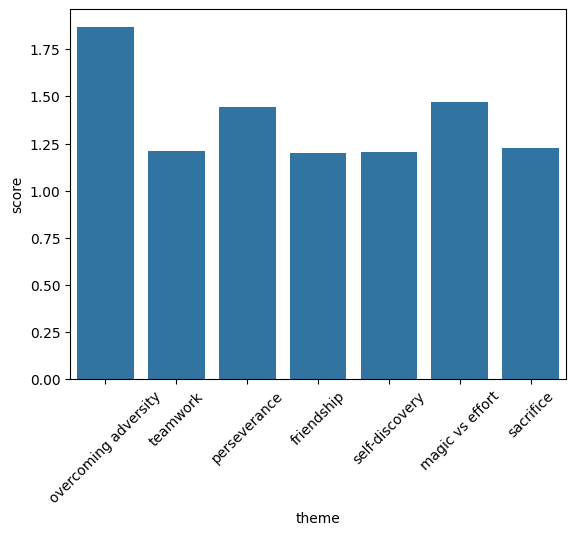

In [88]:
sns.barplot(data = theme_output, x="theme", y="score")
plt.xticks(rotation=45)
plt.show()